In [1]:
import numpy as np
import random as rd

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons, make_circles, make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import src.privacy_ml as ml #import split_horizontally, split_into_random_subsets, stepForward, stepForwardMono, stepForward_2
import src.logistic_reg as lr #import cost
import src.util as util

%load_ext autoreload
%autoreload 2

In [2]:
num_agents = 10
seed = 42

T = 400
mu = 0.05

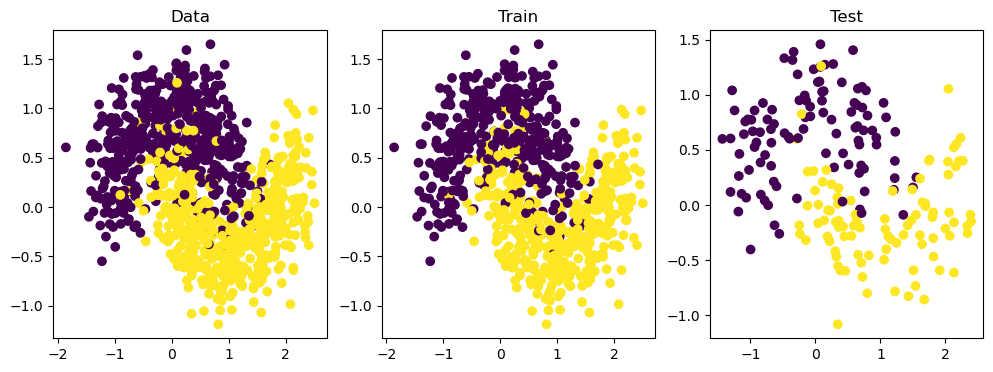

In [3]:
X, Y = make_moons(n_samples=1000, noise=0.3)


Y_formated = OneHotEncoder(categories='auto').fit_transform(Y.reshape(-1,1)).toarray()
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=seed, test_size=0.2)
plt.figure(figsize=(12,4))
plt.subplot(1, 3, 1)
plt.scatter(X[:,0], X[:,1], c=Y)
plt.title("Data")
plt.subplot(1, 3, 2)
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train)
plt.title("Train")
plt.subplot(1, 3, 3)
plt.scatter(X_test[:,0], X_test[:,1], c=Y_test)
plt.title("Test")
plt.show()


On va trier les points par rapport à leur abscisse, pour simuler un effet de proximité entre les points, et utiliser cette proximité pour délimiter les différents agents.

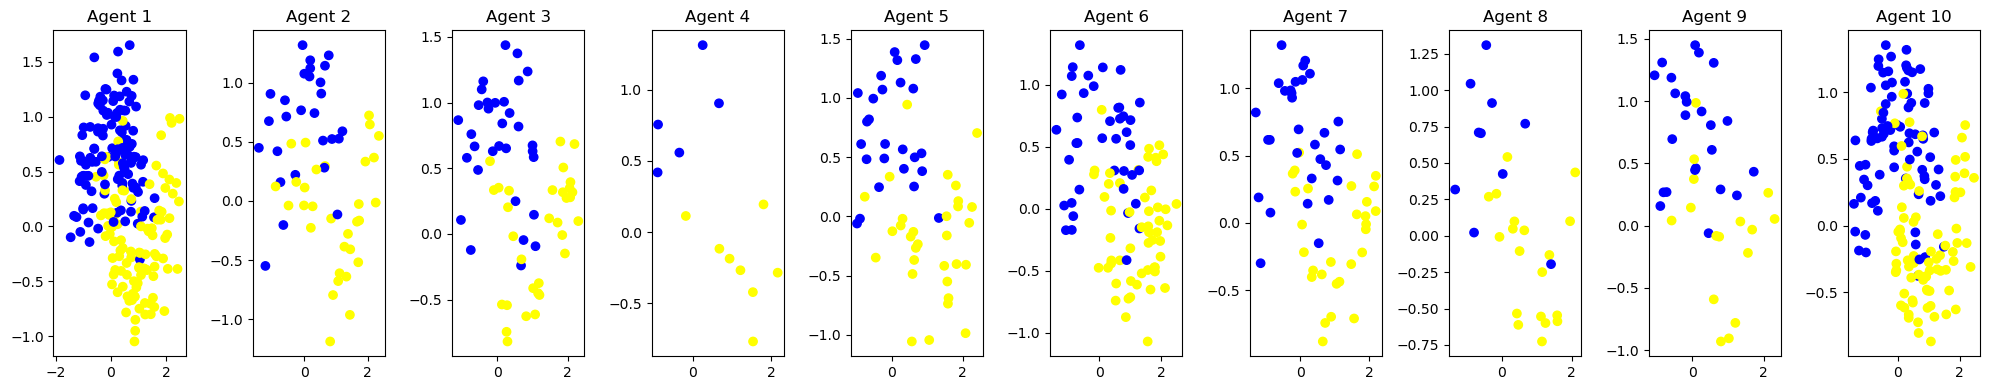

In [4]:

X_agent, Y_agent = ml.split_into_random_subsets(X_train, Y_train, random_state=seed)
#X_agent, Y_agent = ml.split_horizontally(X_train, Y_train)


fig, axes = plt.subplots(nrows=1, ncols=num_agents, figsize=(20, 4))

for i in range(num_agents):
    colors = ['blue' if y== 0 else 'yellow' for y in Y_agent[i]]
    axes[i].scatter(X_agent[i][:,0], X_agent[i][:,1], c=colors)
    axes[i].set_title(f'Agent {i+1}')

plt.tight_layout()
plt.show()

In [5]:
X_agent_augmented = []
for i in range(num_agents):
    X_agent_augmented.append(np.concatenate([X_agent[i], X_agent[i]**2, X_agent[i]**3, X_agent[i]**4], axis=1))

In [6]:
X_test_augmented = np.concatenate([X_test, X_test**2, X_test**3, X_test**4], axis=1)
X_train_augmented = np.concatenate([X_train, X_train**2, X_train**3, X_train**4], axis=1)

In [7]:
G = np.zeros((num_agents, num_agents))
for i in range(num_agents):
    for j in range(num_agents):
        if j == i+1 or j == i-1:
            G[i,j] = 1  
    
D = np.zeros(num_agents)
c = np.zeros(num_agents)

maxSize = np.max([x.shape[0] for x in X_agent])
print(f"Max: {maxSize}")
minSize = np.min([x.shape[0] for x in X_agent])
print(f"Min: {minSize}")
meanSize = np.mean([x.shape[0] for x in X_agent])
print(f"Mean: {meanSize}")
for i in range(num_agents):
    D[i] = np.sum(G[i,:])
    c[i] = X_agent[i].shape[0]/maxSize

print(f"G: {G}")
print(f"D: {D}")
print(f"c: {c}")

Max: 225
Min: 13
Mean: 80.0
G: [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
D: [1. 2. 2. 2. 2. 2. 2. 2. 2. 1.]
c: [1.         0.25777778 0.28444444 0.05777778 0.25333333 0.41777778
 0.26222222 0.12888889 0.17777778 0.71555556]


## Logistic Regression and Gradient Descent


In linear regression, we got a real-valued response
	
$$\hat{y} = \theta_0 + \theta_1 x_1 + \cdots + \theta_d x_d,$$
    
i.e., a linear combination of inputs, where $\hat{y} \in \mathbf{R}$.

In classification, we want an *indication* of how likely an instance is to belong to a particular class; a probability $\in [0,1]$.  

Given a real valued $z$, we can squish it to range $\sigma(z) \in [0,1]$ by feeding it through the **logistic function** aka **sigmoid function**:
		
\begin{equation}
\sigma(z) = \frac{1}{1+\exp(-z)}. \hspace{1.5cm}(1)
\end{equation}

Which looks like this: ![Sigmoid](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/320px-Logistic-curve.svg.png)

Therefore, we can treat this as a probability, i.e.,

\begin{align*}
P(y=1|\mathbf{x}) &= \sigma(\mathbf{\theta}^\top\mathbf{x}), \\
P(y=0|\mathbf{x}) &= 1 - \sigma(\mathbf{\theta}^\top\mathbf{x}), 
\end{align*}

where we omit the bias term and suppose that both $\mathbf{\theta}$ and $\mathbf{x}$ are column vectors.

In order to chose values for the parameters of logistic regression, we use **maximum likelihood estimation** (MLE). As such we are going to have two steps:

1. write the likelihood function;
2. find the values of $\theta$ that maximize the log-likelihood function.


We begin by defining the design matrix $X \in \mathbb{R}^{n,d}$ containing our data points $x_i^T \in \mathbb{R}^{1\times d}$ on its rows and our column vector of model paramters $\theta \in \mathbb{R}^{d\times 1}.$
The labels that we are predicting are binary, this means that we can interpret each label as a Bernoulli random variable: $Y \sim Ber(p)$ where $p = \sigma(\mathbf{\theta}^\top\mathbf{x})$.

Therefore, we can write the probability of a data point as
$$
P\left(Y=y|X=\mathbf{x}\right) = \sigma(\mathbf{\theta}^\top\mathbf{x})^y \cdot \left[1-\sigma(\mathbf{\theta}^\top\mathbf{x})\right]^{(1-y)}.
$$

Given this probability mass function we can now write the **likelihood** of the whole dataset

\begin{equation}
L(\theta) = \prod_{i=1}^n P(Y = y_i|\mathbf{X} = \mathbf{x}_i) = \prod_{i=1}^n \sigma(\mathbf{\theta}^\top\mathbf{x}_i)^{y_i} \cdot \left[1-\sigma(\mathbf{\theta}^\top\mathbf{x}_i)\right]^{(1-y_i)}. \hspace{1.5cm}(2)
\end{equation}

We can take the log of this function to transform the product into a sum and by doing that, we obtain the **log-likelihood**

\begin{equation}
LL(\theta) = \sum_{i=1}^n \left( y_i\log{\sigma(\mathbf{\theta}^\top\mathbf{x}_i)} + (1-y_i) \log{\left[1-\sigma(\mathbf{\theta}^\top\mathbf{x}_i)\right]} \right). \hspace{1.5cm}(3)
\end{equation}

As you will remember from the first lab, our objective is to minimize the error by fitting our model to the data. However, the log-likelihood increases when the model is fitting better to the data. That's the reason why in logistic regression we take the *negative* log-likelihood (also known as **cost** function $E(\theta)$).

On a : $l(\theta) = - \sum_{i=1}^n \left( y_i\log{\sigma(\mathbf{\theta}^\top\mathbf{x}_i)} + (1-y_i) \log{\left[1-\sigma(\mathbf{\theta}^\top\mathbf{x}_i)\right]} \right).$
donc la dérivée vaut : $\nabla _\theta l(\theta) = -\sum_{i=1}^n y_i (1-\sigma(\theta^Tx_i))x_i - (1-y_i) \sigma(\theta^Tx_i)x_i $

$ \nabla_\theta l(\theta) = -\sum_{i=1}^n (y_i - \sigma(\theta^Tx_i)) x_i $

Besoin du coeff de Lipschitz mais : https://proceedings.neurips.cc/paper_files/paper/2018/file/d54e99a6c03704e95e6965532dec148b-Paper.pdf

Supposons que le sigmoid soit L-lip
Alors 

$ \nabla_\theta l(\theta_0) - \nabla_\theta l(\theta_1)  = -\sum_{i=1}^n (\sigma(\theta_1^Tx_i) - \sigma(\theta_0^Tx_i)) x_i$

$| \nabla_\theta l(\theta_0) - \nabla_\theta l(\theta_1) |_2 \leq \sum_{i=1}^n L|(\theta_1^T - \theta_0^T)x_i| | x_i |_2  \leq \sum_{i=1}^n L|\theta_1^T - \theta_0|_2 |x_i|_2 | x_i |_2 $

Or on a $L = \frac{1}{4} $


## Training

### Single Global Model

In [8]:
np.random.seed(seed)
thetas_mono = np.random.rand(X_train_augmented.shape[1])
costs_train_mono = np.zeros((T))
costs_test_mono = np.zeros((T))

for i in range(T):
    thetas_mono = ml.stepForwardMono(thetas_mono, X_train_augmented, Y_train)
    costs_train_mono[i] = lr.cost(thetas_mono, X_train_augmented, Y_train)
    costs_test_mono[i] = lr.cost(thetas_mono, X_test_augmented, Y_test)
    if i % (T/10) == 0:
                print(f'Iteration {i} : Train: {costs_train_mono[i]:.4f} | Test: {costs_test_mono[i]:.4f}')

# np.random.seed(seed)
# thetas_agents_globalModel = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]

# costs_train_agents_globalModel = np.zeros((T, num_agents))
# costs_test_agents_globalModel = np.zeros((T, num_agents))

# print(T)
# for i in range(T):
#     thetas_agents_globalModel = ml.stepForward(thetas_agents_globalModel, X_agent_augmented, Y_agent, num_agents, 0, c, G, D)
#     for j in range(num_agents):
#             costs_train_agents_globalModel[i,j] = lr.cost(thetas_agents_globalModel[j], X_agent_augmented[j], Y_agent[j])
#             costs_test_agents_globalModel[i,j] = lr.cost(thetas_agents_globalModel[j], X_test_augmented, Y_test)
#     if i % 1000 == 0 :
#         print(f'Iteration {i+1} : Train: {np.mean(costs_train_agents_globalModel[i]):.4f} and {np.std(costs_train_agents_globalModel[i]):.4f} | Test: {np.mean(costs_test_agents_globalModel[i]):.4f} and {np.std(costs_test_agents_globalModel[i]):.4f}')

Iteration 0 : Train: 1.2550 | Test: 1.2748
Iteration 40 : Train: 0.6051 | Test: 0.6154
Iteration 80 : Train: 0.4603 | Test: 0.4673
Iteration 120 : Train: 0.4157 | Test: 0.4190
Iteration 160 : Train: 0.3923 | Test: 0.3928
Iteration 200 : Train: 0.3773 | Test: 0.3756
Iteration 240 : Train: 0.3667 | Test: 0.3633
Iteration 280 : Train: 0.3588 | Test: 0.3539
Iteration 320 : Train: 0.3525 | Test: 0.3465
Iteration 360 : Train: 0.3475 | Test: 0.3403


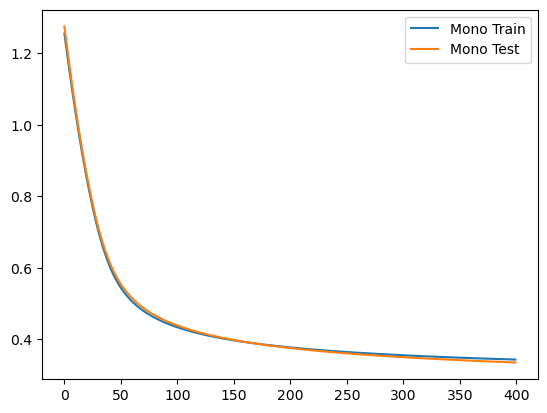

In [9]:
plt.plot(costs_train_mono, label="Mono Train")
plt.plot(costs_test_mono, label="Mono Test")
plt.legend()
plt.show()

# util.plot_curves(num_agents, costs_train_agents_globalModel, costs_test_agents_globalModel, "Multiple Agents")

### Multiple agents

Agents dont share their models (perfectly private baseline)

In [10]:
np.random.seed(seed)
thetas_agents_alone = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]

costs_train_agents_alone = np.zeros((T, num_agents))
costs_test_agents_alone = np.zeros((T, num_agents))
costs_train_alone = np.zeros(T)
costs_test_alone = np.zeros(T)

print("Iter: Agents_Mean       | Total ")
for i in range(T):
    thetas_agents_alone = ml.stepForwardAlone(thetas_agents_alone, X_agent_augmented, Y_agent, num_agents, mu, c, G, D)
    for j in range(num_agents):
            costs_train_agents_alone[i,j] = lr.cost(thetas_agents_alone[j], X_agent_augmented[j], Y_agent[j])
            costs_test_agents_alone[i,j] = lr.cost(thetas_agents_alone[j], X_test_augmented, Y_test)
    costs_train_alone[i] = lr.costDecentralized(thetas_agents_alone, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
    costs_test_alone[i] = lr.costDecentralized(thetas_agents_alone, X_test_augmented, Y_test, num_agents, G, D, c, mu)

    if i % (T/10) == 0 :
        print(f'{i:3} : ({np.mean(costs_train_agents_alone[i]):.4f} , {np.mean(costs_test_agents_alone[i]):.4f}) | ({costs_train_alone[i]:.4f} , {costs_test_alone[i]:.4f})')

Iter: Agents_Mean       | Total 
  0 : (1.1083 , 1.1709) | (6.6066 , 6.3405)
 40 : (0.5338 , 0.6110) | (5.4815 , 5.3500)
 80 : (0.4217 , 0.4789) | (4.9967 , 4.8905)
120 : (0.3810 , 0.4287) | (4.9184 , 4.8210)
160 : (0.3594 , 0.4034) | (5.0050 , 4.9124)
200 : (0.3454 , 0.3878) | (5.1651 , 5.0756)
240 : (0.3355 , 0.3772) | (5.3713 , 5.2842)
280 : (0.3280 , 0.3693) | (5.6125 , 5.5271)
320 : (0.3220 , 0.3633) | (5.8819 , 5.7979)
360 : (0.3171 , 0.3585) | (6.1748 , 6.0920)


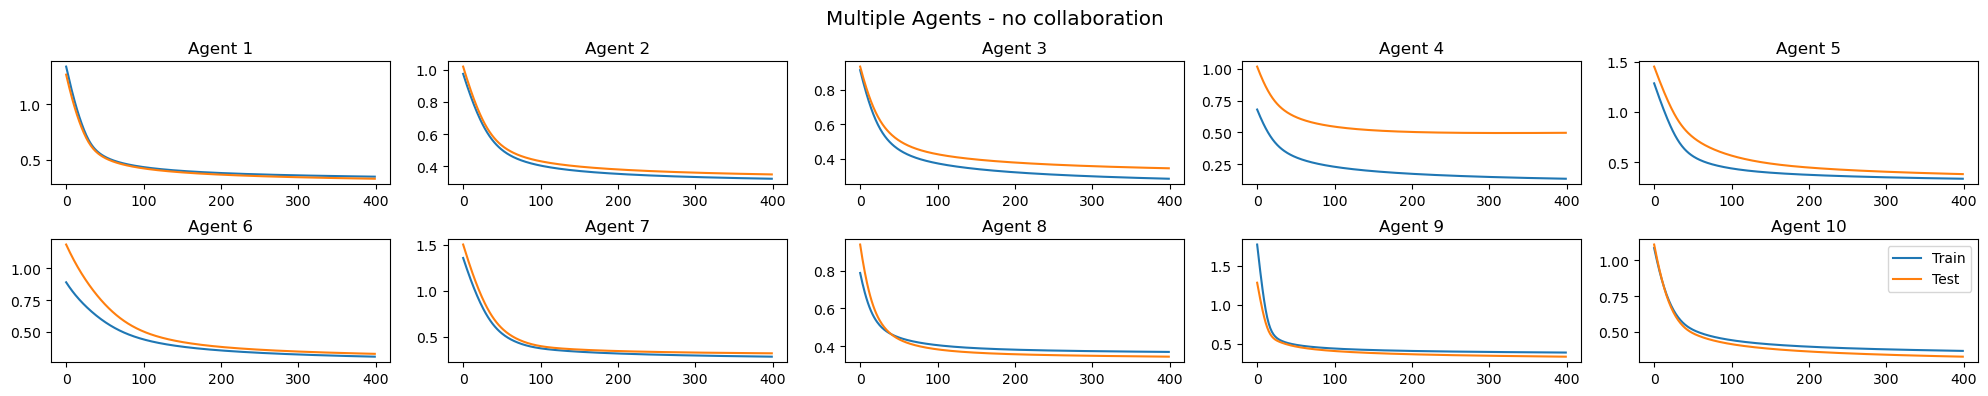

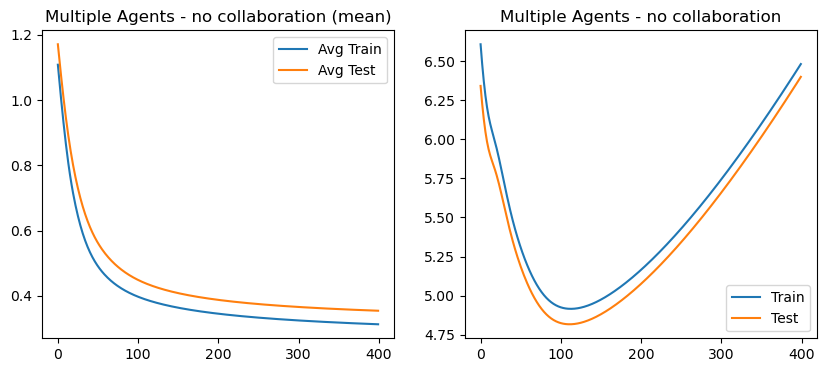

In [11]:
util.plot_curves(num_agents, costs_train_agents_alone, costs_test_agents_alone, costs_train_alone, costs_test_alone, "Multiple Agents - no collaboration")

### Multiple agents

All agents do a step after each other in a naive queue and share their models

In [12]:
np.random.seed(seed)
thetas_agents = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]

costs_train_agents = np.zeros((T, num_agents))
costs_test_agents = np.zeros((T, num_agents))
costs_train = np.zeros(T)
costs_test = np.zeros(T)

print("Iter: Agents_Mean       | Total ")
for i in range(T):
    thetas_agents = ml.stepForward(thetas_agents, X_agent_augmented, Y_agent, num_agents, mu, c, G, D)
    for j in range(num_agents):
            costs_train_agents[i,j] = lr.cost(thetas_agents[j], X_agent_augmented[j], Y_agent[j])
            costs_test_agents[i,j] = lr.cost(thetas_agents[j], X_test_augmented, Y_test)
    costs_train[i] = lr.costDecentralized(thetas_agents, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
    costs_test[i] = lr.costDecentralized(thetas_agents, X_test_augmented, Y_test, num_agents, G, D, c, mu)
    if i % (T/10) == 0 :
        print(f'{i:3} : ({np.mean(costs_train_agents[i]):.4f} , {np.mean(costs_test_agents[i]):.4f}) | ({costs_train[i]:.4f} , {costs_test[i]:.4f})')

Iter: Agents_Mean       | Total 
  0 : (1.1186 , 1.1897) | (4.7073 , 4.4408)
 40 : (0.5534 , 0.5976) | (0.4076 , 0.2745)
 80 : (0.4346 , 0.4617) | (0.2347 , 0.1269)
120 : (0.3922 , 0.4138) | (0.1818 , 0.0829)
160 : (0.3696 , 0.3878) | (0.1562 , 0.0622)
200 : (0.3553 , 0.3708) | (0.1408 , 0.0501)
240 : (0.3452 , 0.3587) | (0.1307 , 0.0424)
280 : (0.3377 , 0.3494) | (0.1238 , 0.0373)
320 : (0.3319 , 0.3421) | (0.1189 , 0.0338)
360 : (0.3272 , 0.3361) | (0.1153 , 0.0314)


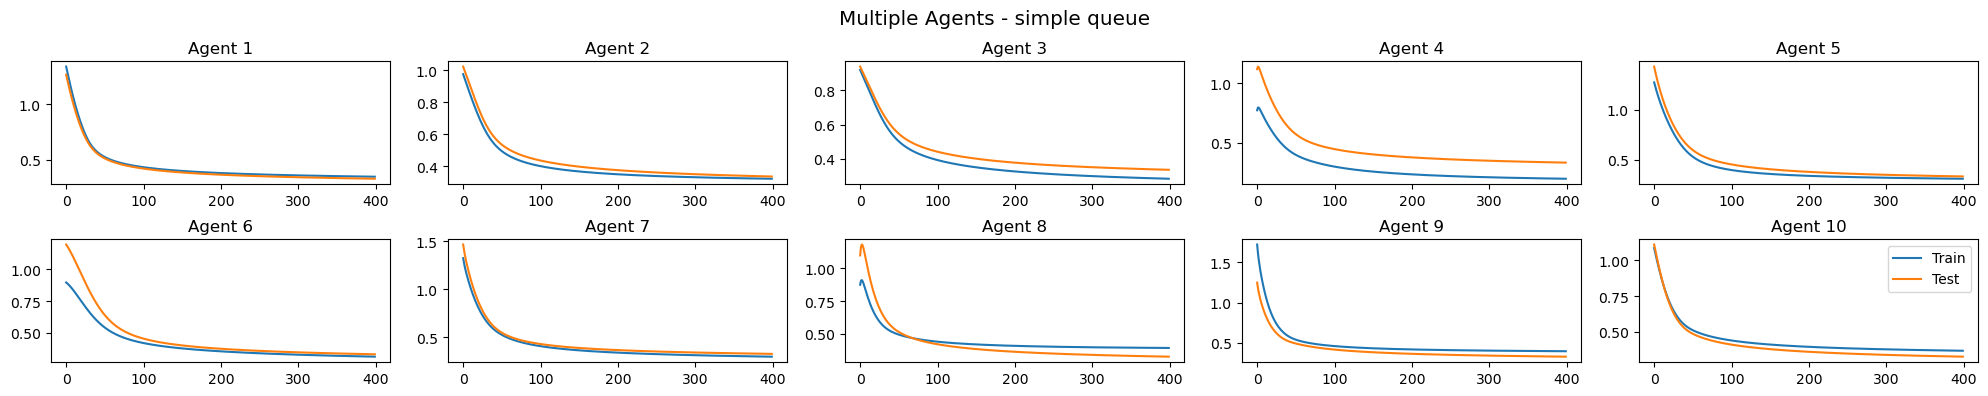

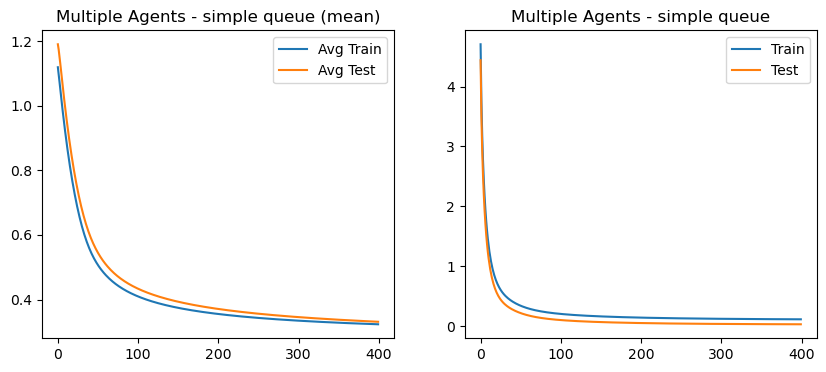

In [13]:
util.plot_curves(num_agents, costs_train_agents, costs_test_agents, costs_train, costs_test, "Multiple Agents - simple queue")

### Random drawing of Agents

randint with global quota

In [14]:
np.random.seed(seed)
tracking  = np.zeros(num_agents) # pour mesurer le nombre de fois que chaque agent passe
total_T = T*num_agents

thetas_agents_rand = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]
costs_test_agents_rand = np.zeros((total_T, num_agents))                 # ici on ne gardera en mémoire que les dernières valeurs
costs_train_agents_rand = np.zeros((total_T, num_agents))
costs_test_rand = np.zeros(total_T)
costs_train_rand = np.zeros(total_T)


print("Iter: Agents_Mean       | Total ")
for i in range (total_T) :
    j = rd.randint(0, num_agents-1)
    tracking[j] += 1

    thetas_agents_rand = ml.stepForward_2(thetas_agents_rand, X_agent_augmented, Y_agent, j, num_agents, mu, c, G, D) 

    costs_train_agents_rand[i, j] = lr.cost(thetas_agents_rand[j], X_agent_augmented[j], Y_agent[j])
    costs_test_agents_rand[i, j] = lr.cost(thetas_agents_rand[j], X_test_augmented, Y_test)

    if i % 10 == 0:
        costs_train_rand[int(i/10)] = lr.costDecentralized(thetas_agents_rand, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
        costs_test_rand[int(i/10)] = lr.costDecentralized(thetas_agents_rand, X_test_augmented, Y_test, num_agents, G, D, c, mu)
        
    if i % ((T/10)*num_agents) == 0 :
        print(f'{int(i/num_agents):3} : ({np.mean(costs_train_agents_rand[i]):.4f} , {np.mean(costs_test_agents_rand[i]):.4f}) | ({costs_train_rand[int(i/10)]:.4f} , {costs_test_rand[int(i/10)]:.4f})')

costs_train_agents_rand = util.reduce_cost_matrix(costs_train_agents_rand)
costs_test_agents_rand = util.reduce_cost_matrix(costs_test_agents_rand)
costs_train_rand = costs_train_rand[:T]
costs_test_rand = costs_test_rand[:T]

Iter: Agents_Mean       | Total 
  0 : (0.0976 , 0.1024) | (6.5476 , 6.2758)
 40 : (0.0592 , 0.0659) | (0.4239 , 0.2910)
 80 : (0.0327 , 0.0476) | (0.2279 , 0.1197)
120 : (0.0286 , 0.0430) | (0.1867 , 0.0877)
160 : (0.0341 , 0.0391) | (0.1580 , 0.0639)
200 : (0.0347 , 0.0372) | (0.1416 , 0.0507)
240 : (0.0314 , 0.0365) | (0.1333 , 0.0447)
280 : (0.0322 , 0.0350) | (0.1269 , 0.0402)
320 : (0.0403 , 0.0341) | (0.1194 , 0.0341)
360 : (0.0320 , 0.0339) | (0.1163 , 0.0322)


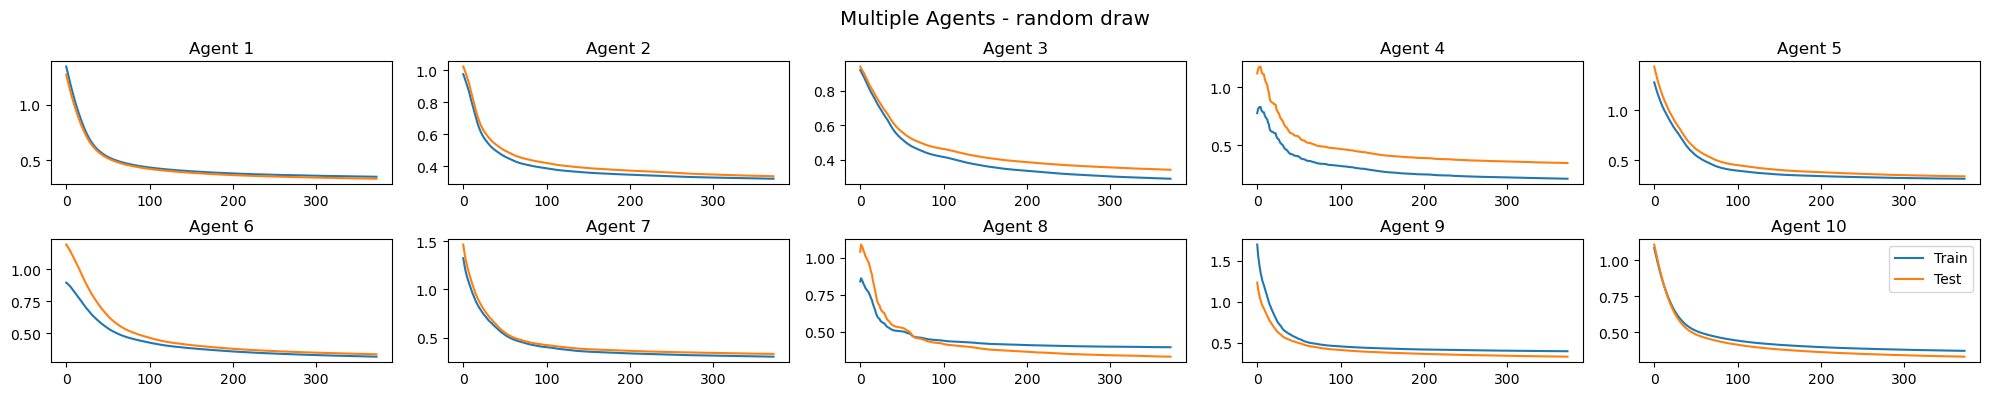

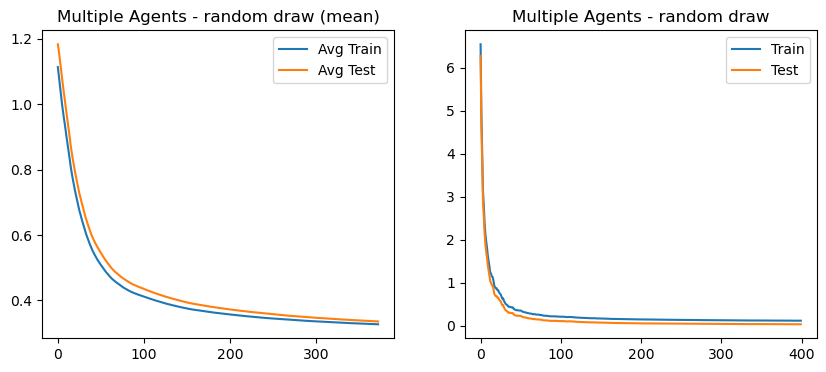

In [15]:
util.plot_curves(num_agents, costs_train_agents_rand, costs_test_agents_rand, costs_train_rand, costs_test_rand, "Multiple Agents - random draw")

### Weighting of Agents

In [16]:
np.random.seed(seed)
tracking  = np.zeros(num_agents)
total_T = T*num_agents

thetas_agents_weigh = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]
costs_test_agents_weigh = np.zeros((total_T, num_agents))                 # ici on ne gardera en mémoire que les dernières valeurs
costs_train_agents_weigh = np.zeros((total_T, num_agents))
costs_test_weigh = np.zeros(total_T)
costs_train_weigh = np.zeros(total_T)


# on obtient les probabilités qu'on veut pour chaque modèle à chaque tirage
coeffs_pond = np.zeros(num_agents)
c_tot = 0
for i in range (len(c)) :
    c_tot += c[i]    
for i in range (len(c)) :
    coeffs_pond[i] = c[i]/c_tot
    
print(coeffs_pond)
print("Iter: Agents_Mean       | Total ")

for i in range(total_T) :
    j = np.random.choice(10, 1, p=coeffs_pond)[0]
    tracking[j] += 1

    thetas_agents_weigh = ml.stepForward_2(thetas_agents_weigh, X_agent_augmented, Y_agent, j, num_agents, mu, c, G, D) # y'a probleme

    costs_train_agents_weigh[i, j] = (lr.cost(thetas_agents_weigh[j], X_agent_augmented[j], Y_agent[j]))
    costs_test_agents_weigh[i, j] = (lr.cost(thetas_agents_weigh[j], X_test_augmented, Y_test))

    if i % 10 == 0:
        costs_train_weigh[int(i/10)] = lr.costDecentralized(thetas_agents_weigh, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
        costs_test_weigh[int(i/10)] = lr.costDecentralized(thetas_agents_weigh, X_test_augmented, Y_test, num_agents, G, D, c, mu)
        
        
    if i % ((T/10)*num_agents) == 0 :
        print(f'{int(i/num_agents):3} : ({np.mean(costs_train_agents_weigh[i]):.4f} , {np.mean(costs_test_agents_weigh[i]):.4f}) | ({costs_train_weigh[int(i/10)]:.4f} , {costs_test_weigh[int(i/10)]:.4f})')

# costs_train_agents_weigh = util.reduce_cost_matrix(costs_train_agents_weigh)
# costs_test_agents_weigh = util.reduce_cost_matrix(costs_test_agents_weigh)

costs_train_agents_weigh_shifted = util.shift_non_zero_costs_to_front(costs_train_agents_weigh)
costs_test_agents_weigh_shifted = util.shift_non_zero_costs_to_front(costs_test_agents_weigh)

non_zero_counts = np.count_nonzero(costs_train_agents_weigh_shifted, axis=0)    
max_non_zero = np.max(non_zero_counts)
costs_train_weigh = costs_train_weigh[:max_non_zero]
costs_test_weigh = costs_test_weigh[:max_non_zero]


[0.28125 0.0725  0.08    0.01625 0.07125 0.1175  0.07375 0.03625 0.05
 0.20125]
Iter: Agents_Mean       | Total 
  0 : (0.1088 , 0.1113) | (6.6646 , 6.3933)
 40 : (0.0600 , 0.0727) | (0.7541 , 0.6221)
 80 : (0.0393 , 0.0378) | (0.4327 , 0.3268)
120 : (0.0409 , 0.0440) | (0.3659 , 0.2684)
160 : (0.0352 , 0.0376) | (0.2756 , 0.1830)
200 : (0.0355 , 0.0337) | (0.2333 , 0.1440)
240 : (0.0350 , 0.0331) | (0.2005 , 0.1135)
280 : (0.0326 , 0.0340) | (0.1799 , 0.0946)
320 : (0.0321 , 0.0350) | (0.1709 , 0.0870)
360 : (0.0396 , 0.0328) | (0.1623 , 0.0794)


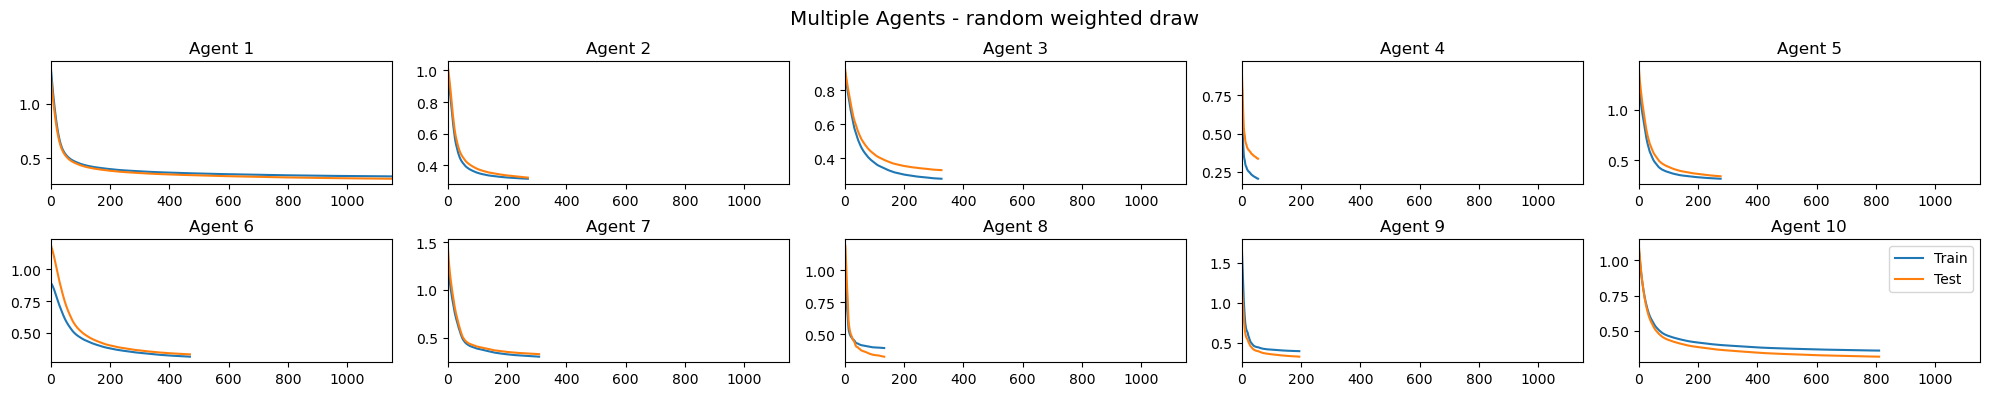

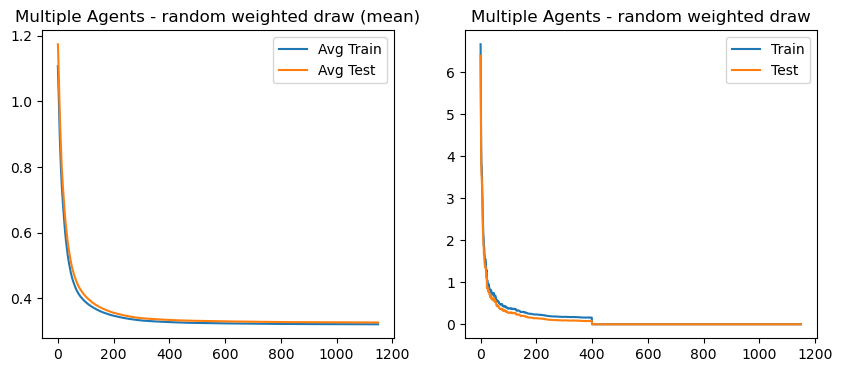

In [17]:
util.plot_curves_non_zero(num_agents, costs_train_agents_weigh_shifted, costs_test_agents_weigh_shifted, costs_train_weigh, costs_test_weigh, "Multiple Agents - random weighted draw")

## With Privacy

On fait avec $\delta = 0$ et $\epsilon_i(t_i) = \epsilon$

Si on veut partir du $\bar{\epsilon}$, on va utiliser $\delta$ et $\bar{\delta}$ tous nuls, et utiliser le théorème 1 (et la proposition 2 dans un deuxième temps) pour obtenir des epsilon.


In [27]:
epsilon = 0.25
L_0 = 0.25

# définit epsilon_barre
epsilon_barre = 3

# technique naïve pour retrouver epsilon : le même à chaque étape

# epsilon = epsilon_barre / T # pour stepForwardPrivate normal

# il faut réestimer le epsilon_barre lorsque le nombre d'étapes d'entraînement pour un modèle n'est pas exactement T 

np.random.seed(seed)
thetas_private = [np.random.rand(X_agent_augmented[i].shape[1]) for i in range(num_agents)]

costs_train_private = np.zeros(T)
costs_test_private = np.zeros(T)

for i in range(T):
    thetas_private = ml.stepForwardPrivate(thetas_private, X_agent_augmented, Y_agent, num_agents, mu, c, G, D, L_0, epsilon)
    costs_train_private[i] = lr.costDecentralized(thetas_private, X_agent_augmented, Y_agent, num_agents, G, D, c, mu)
    costs_test_private[i] = lr.costDecentralized(thetas_private, X_test_augmented, Y_test, num_agents, G, D, c, mu)
    if i % (T/10) == 0 :
        print(f'Iteration {i} : Train: {costs_train_private[i]:.4f} | Test: {costs_test_private[i]:.4f}')

Iteration 0 : Train: 4.8224 | Test: 4.5564
Iteration 40 : Train: 0.4866 | Test: 0.3536
Iteration 80 : Train: 0.4446 | Test: 0.3366
Iteration 120 : Train: 0.4997 | Test: 0.4000
Iteration 160 : Train: 0.2619 | Test: 0.1683
Iteration 200 : Train: 0.2811 | Test: 0.1905
Iteration 240 : Train: 0.1886 | Test: 0.1006
Iteration 280 : Train: 0.2019 | Test: 0.1154
Iteration 320 : Train: 0.2025 | Test: 0.1172
Iteration 360 : Train: 0.3007 | Test: 0.2170


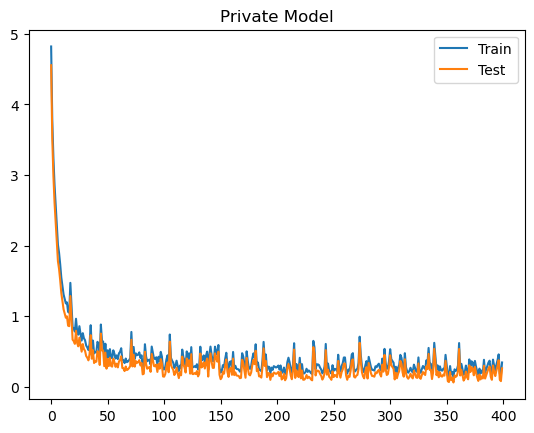

In [28]:
plt.plot(costs_train_private, label="Train")
plt.plot(costs_test_private, label="Test")
plt.title("Private Model")
plt.legend()
plt.show()

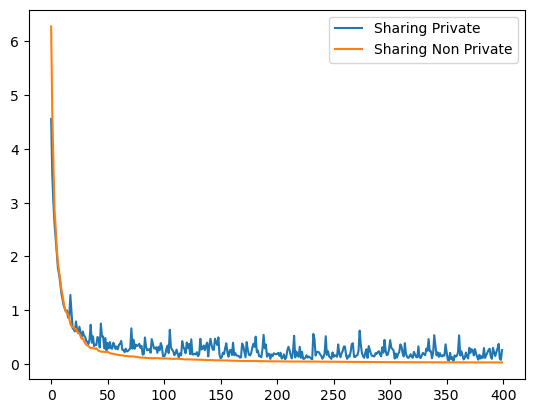

In [29]:
plt.plot(costs_test_private, label="Sharing Private")
#plt.plot(costs_test_alone, label="No Sharing")
plt.plot(costs_test_rand, label="Sharing Non Private")
plt.legend()
plt.show()